In [3]:
#!pip install miceforest --no-cache-dir

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import make_scorer
import miceforest as mf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='combo_lavSQ_MHC'
print(fileloc_data)
#sys.path.append('/'.join(os.getcwd().split('/')[0:4])+'/nan_smote/')
from FigPlotting import clusterPlot, plot_dendrogram
#############################################
#df_main.head(3)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/


In [2]:
df_all_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainDect_ED_SQ48_MHC_Honos_Lav.tsv', sep='\t', decimal=',')
print(df_all_combo['pid'].nunique(),df_all_combo['intid'].nunique())
pid_per_intid=df_all_combo['pid'].value_counts()
print('PIDs repeated in INTIDs: ', pid_per_intid[pid_per_intid.values>1])
df_all_combo[['EDtype', 'Split']].value_counts()

132 132
PIDs repeated in INTIDs:  Series([], Name: count, dtype: int64)


EDtype            Split
Anorexia nervosa  Train    35
Binge-ED          Train    20
Other ED          Train    17
Anorexia nervosa  Test     16
Bulimia nervosa   Train    13
Others            Train    12
Binge-ED          Test      8
Other ED          Test      5
Bulimia nervosa   Test      3
Others            Test      3
Name: count, dtype: int64

### Correlation Matrix of the combined datasets

In [3]:
#df_Question_EDEQ=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
df_Question_EDEQ=df_all_combo.copy()
df_Question_EDEQ['aantal_eerdere_trajecten'].loc[df_Question_EDEQ['aantal_eerdere_trajecten'].isnull()]=0
df_Question_EDEQ['duur_stoornis_in_jaren'].loc[df_Question_EDEQ['duur_stoornis_in_jaren'].isnull()]=0
df_edeq=pd.read_csv(fileloc_data+'maskedDAIsy_EDEQ_Score.tsv', sep='\t', decimal=',')
#print(df_edeq.columns)
df_edeq['intid'] = df_edeq['intid'].astype(float)
df_edeq_reqd=df_edeq[['intid', 'seq_num-edeq','eating', 'weight','bodyshape', 'lines']].loc[df_edeq['seq_num-edeq']==1].copy()
df_Question_EDEQ=pd.merge(df_edeq_reqd, df_Question_EDEQ, on='intid', how='inner')
colsDectools=['BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', 'duur_stoornis_in_jaren', 
    'IND_depressie_comorbiditeit','IND_borderline_comorbiditeit', 'IND_ocd_comorbiditeit', 'IND_anders','IND_ernstig_verstoord_eten']
df_Question_EDEQ.astype(dict(zip(colsDectools, ['float', 'float','float', 'float', 'float','float','float',
                                               'float','float','float','float','float']))).dtypes
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines']
df_Question_EDEQ.astype(dict(zip(colsEDEQ, ['float', 'float','float', 'float']))).dtypes
colsHonos=['Somscore', 'Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
df_Question_EDEQ.astype(dict(zip(colsHonos, ['float', 'float','float', 'float', 'float','float']))).dtypes
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid', 'LAV_Score']
df_Question_EDEQ.astype(dict(zip(colsLAV, ['float', 'float','float', 'float']))).dtypes
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie', 'SQ48score']
df_Question_EDEQ.astype(dict(zip(colsSQ48, ['float', 'float','float', 'float', 'float','float','float',
                                               'float','float','float']))).dtypes
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB', 'mhcsf_score']
df_Question_EDEQ.astype(dict(zip(colsMHCSF, ['float', 'float','float', 'float']))).dtypes
colNames=['Main-Age', 'Main-BSex','Main-EduLevel', 'Main-ED_Codes', 'EDEQ-score','EDEQ-eating', 'EDEQ-weight', 'EDEQ-bodyshape',
'EDEQ-lines', 'DT-BMI', 'DT-IND_prev_spec_int_wo_eff', 'DT-num_prev_routes', 
'DT-Disorder_Duration_Yrs', 'DT-IND_depressie_CMD','DT-IND_BDL_CMD', 'DT-IND_OCD_CMD', 'DT-IND_others',
'DT-IND_VDisturbdEating', 'Honos-Somscore', 'Honos-Beperkingen','Honos-Functioneren', 'Honos-Gedragsproblemen', 
'Honos-Symptomalogie', 'Honos-SocialeProblemen','Lav-Neg_Waardering','Lav-Gebrek_Vertrouwdheid', 'Lav-Alg_Ontevredenheid', 
'Lav-Score', 'SQ48-Hostility','SQ48-Agorafobie','SQ48-Angst','SQ48-Depressie','SQ48-Cognitieve_Complain',
'SQ48-Somatische_Complain', 'SQ48-Sociale_Fobie','SQ48-Vitaliteit_Optimisme','SQ48-Werk_Studie', 'SQ48-Score', 
'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB', 'MHCSF-Score']  

df_Question_EDEQ['BMI']=df_Question_EDEQ['BMI'].astype(float)
df_Question_EDEQ['duur_stoornis_in_jaren']=df_Question_EDEQ['duur_stoornis_in_jaren'].astype(float)
df_Question_EDEQ['bsex'] = df_Question_EDEQ['bsex'].astype('category')
df_Question_EDEQ['biosex'] = df_Question_EDEQ['bsex'].cat.codes
df_Question_EDEQ['biosex']=df_Question_EDEQ['biosex'].astype(float)
df_Question_EDEQ['EDtype'] = df_Question_EDEQ['EDtype'].astype('category')
df_Question_EDEQ['ED_Codes'] = df_Question_EDEQ['EDtype'].cat.codes
df_Question_EDEQ['Highest_Edu'] = df_Question_EDEQ['Highest_Edu'].astype('category')
df_Question_EDEQ['Education'] = df_Question_EDEQ['Highest_Edu'].cat.codes
df_Question_EDEQ['Education']=df_Question_EDEQ['Education'].astype(float)
df_train_explore=df_Question_EDEQ.loc[df_Question_EDEQ['Split']=='Train']
df_test_explore=df_Question_EDEQ.loc[df_Question_EDEQ['Split']=='Test']
print(df_train_explore['bsex'].value_counts())
print(df_train_explore['EDtype'].value_counts())
cols2consider=['age','biosex', 'Education','ED_Codes','EDEQscore']+colsEDEQ+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF
colRename_dict=dict(zip(cols2consider, colNames))
df_all_combo.rename(columns=colRename_dict, inplace=True)
ED_info=['intid','EDtype','EDEQscore', 'Split']
all_scores=['intid', 'Honos-Somscore', 'LAV-Score', 'SQ48-Score', 'MHCSF-Score', 'Split']

bsex
Vrouw    93
Man       4
Name: count, dtype: int64
EDtype
Anorexia nervosa    35
Binge-ED            20
Other ED            17
Bulimia nervosa     13
Others              12
Name: count, dtype: int64


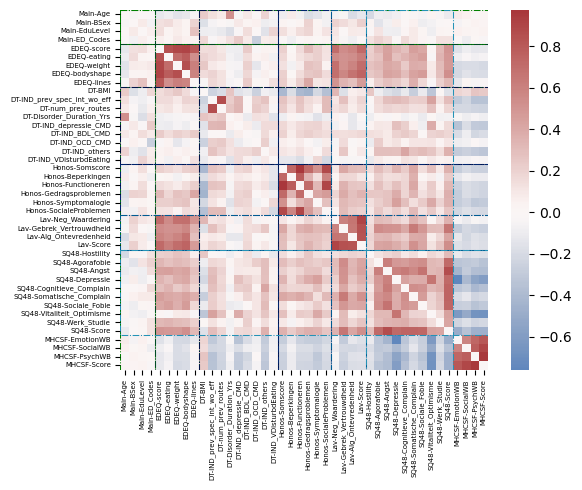

In [4]:
#df_dec_mhcsf_sq48
import matplotlib.patches as patches
#cols2consider=np.setdiff1d(cols2consider, ['EDtypes', 'bsex'])+['Edu_codes', 'ED_Codes']
cc_df_train_explore=df_train_explore[cols2consider].corr(method='spearman')
np.fill_diagonal(cc_df_train_explore.values, 0)
cc_col_dict=dict(zip(cc_df_train_explore.columns, colNames))
cc_df_train_explore.rename(columns=cc_col_dict, index=cc_col_dict, inplace=True)
fs=5
#print(df_train_explore['verstoord_eetpatroon'].value_counts())
fig0, ax0=plt.subplots(1,1,figsize=(6,5))
sns.axes_style('ticks')
#sns.set(font_scale=0.8)
sns.heatmap(cc_df_train_explore, cmap="vlag", annot=False, xticklabels=colNames, yticklabels=colNames, ax=ax0, center=0)#ax0.set_xticks(range(0, 39, 1))
ax0.tick_params(axis='x', labelrotation=90)
ax0.tick_params(axis='y', labelrotation=0)
ax0.tick_params(left=True, bottom=True)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize = fs, ha='center')
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize = fs, va='center')
colors = plt.cycler("color", plt.cm.ocean(np.linspace(0, 1, 7+1)))
xy=[[0,0],[4,0],[5+len(colsEDEQ),0],[5+len(colsEDEQ)+len(colsDectools),0],[5+len(colsEDEQ)+len(colsDectools)+len(colsHonos),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)+len(colsMHCSF),0]]
yx=[[0,0],[0,4],[0,5+len(colsEDEQ)],[0,5+len(colsEDEQ)+len(colsDectools)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)+len(colsMHCSF)]]

width, height=[4, len(colsEDEQ)+1,len(colsDectools),len(colsHonos),len(colsLAV),len(colsSQ48),3.0], 44.75
for k, col in zip(range(0,6), colors):
    ax0.add_patch(patches.Rectangle(xy[k],width[k],height,edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
    ax0.add_patch(patches.Rectangle(yx[k],height,width[k],edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
plt.tight_layout()
plt.savefig('figs/PDFs/correlationMatrix_adapted.pdf')
plt.savefig('figs/PNGs/correlationMatrix_adapted.png')

In [5]:
n, unique_pairs = 25,[] # change this to the number of pairs you want to get
top_pairs = cc_df_train_explore.unstack().sort_values(ascending=False)[:n*2]
bottom_pairs = cc_df_train_explore.unstack().sort_values(ascending=True)[:n*2]
# Create a list to store the top pairs without duplicates
# Iterate over the top pairs and add only unique pairs to the list
for pair in top_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
top_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    top_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
unique_pairs, n=[],10
for pair in bottom_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
bottom_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    bottom_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
corr_high_lows=pd.concat([top_pairs_df, bottom_pairs_df])
# Print the top pairs as a dataframe
#display(corr_high_lows)

Correlation matrix suggests the following:
- SQ48 and MHC-SF seem to have interesting negative Spearman correlation coefficients: Discuss with Pia, Joyce, Mladena
- LAV seems to be quite highly correlated with EDEQ score: Discuss if this relation to understand why this is so
- 

### Visualizing Missing Values

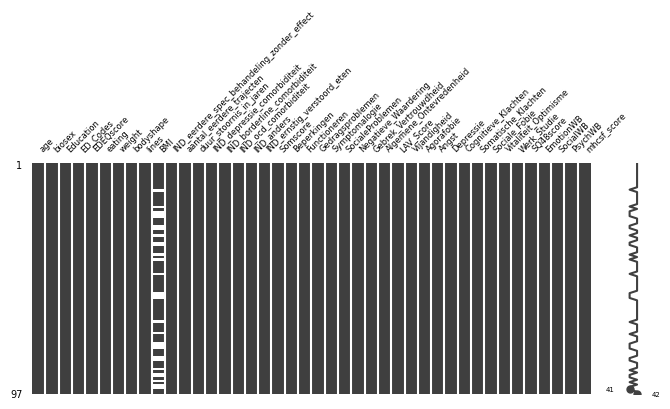

In [6]:
#!pip install missingno
import missingno as msno 
fig = msno.matrix(df_train_explore[cols2consider],figsize=(8, 3), fontsize=6)
grid_ax = fig.axes
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_NaNPatterns.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_NaNPatterns.png'%savetag)

In [7]:
colsDectools=['BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', 
    'duur_stoornis_in_jaren', 'IND_depressie_comorbiditeit', 'IND_borderline_comorbiditeit', 
    'IND_ocd_comorbiditeit', 'IND_anders','IND_ernstig_verstoord_eten']
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines']
#colsEDQOL=['Psychologisch', 'FysiekCognitief','Financieel', 'WerkSchool', 'EDQOLscore']
colsHonos=['Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid']
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie']
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB']
cols2train=['age','biosex', 'Education']+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF
df_train=df_Question_EDEQ[cols2train].loc[df_Question_EDEQ['Split']=='Train'].copy()
df_test=df_Question_EDEQ[cols2train].loc[df_Question_EDEQ['Split']=='Test'].copy()

In [8]:
nan_mean=np.nanmean(df_train[cols2train].to_numpy(), axis=0)
nan_std=np.nanstd(df_train[cols2train].to_numpy(), axis=0)
z_train_explore_nan=((df_train[cols2train].to_numpy()-nan_mean)/nan_std)
z_train_df=pd.DataFrame(data=z_train_explore_nan, columns=cols2train)
kernel_mean_match = mf.ImputationKernel(data=z_train_df,num_datasets=1,mean_match_candidates=5)
kernel_mean_match.mice(10)
z_train_explore=pd.DataFrame(data=kernel_mean_match.complete_data(), columns=cols2train)
z_test_df=pd.DataFrame(data=((df_test[cols2train].to_numpy()-nan_mean)/nan_std), columns=cols2train)
z_test_explore=kernel_mean_match.impute_new_data(z_test_df)

#### Eigenvalue decomposition to PCA
#### PPCA

##### EVD of data $X$: steps:
1. Center $X$: $X_c= X-\hat{X}$
2. Covariance of $X_c$: $C=X_c^{T}X_c$ (This also ensures )
3. Eigenvalue decomposition of Covariance of $X_c$: $eigVal, eigVec=eig(C) $

Shape of eig vec and val (32,) (32, 32)
Shape of evd_z_train_explore (97, 3)
Shape of FA transformed data: (97, 30)
No. of intrinsic dims according to PCA:  32
(32, 32) 32.0 0.0


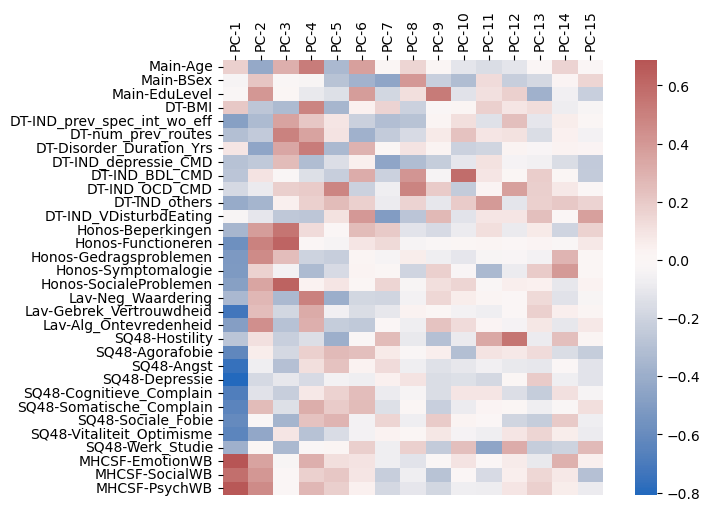

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics
from sklearn.decomposition import FactorAnalysis, PCA
import matplotlib as mpl
#cols2train=np.setdiff1d(cols2train,['EDEQscore','ED_Codes'])
labels_true=df_train_explore['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
eig_val, eig_vec=np.linalg.eig(np.dot(z_train_explore.T, z_train_explore))
print('Shape of eig vec and val', np.shape(eig_val), np.shape(eig_vec))
explained_var=np.cumsum(eig_val/np.sum(eig_val))
sind_eig_val=np.argsort(-1*(explained_var))
ndim=3
evd_z_train_explore=np.dot(z_train_explore,eig_vec[sind_eig_val[:ndim]].T)
print('Shape of evd_z_train_explore', np.shape(evd_z_train_explore))

transformer = FactorAnalysis(n_components=30, random_state=0)
fa_z_train = transformer.fit_transform(z_train_explore)
m, noise = transformer.components_, transformer.noise_variance_
var_expl_fa, m2 = np.zeros(30,), np.sum(m**2,axis=1)
for idx in range(0,30):
    var_expl_fa[idx]=(100*m2[idx])/(np.sum(m2)+np.sum(noise))
print('Shape of FA transformed data:', np.shape(fa_z_train))
pca = PCA(svd_solver='full').fit(z_train_explore)
variance_explained, components=np.cumsum(pca.explained_variance_)*100/np.sum(pca.explained_variance_), pca.components_
print("No. of intrinsic dims according to PCA: ", pca.n_components_)
pca_loadings=pd.DataFrame(data=pca.components_.T * np.sqrt(pca.explained_variance_), 
                          index=z_test_df.columns, columns=['PC-'+str(x) for x in range(1,pca.n_components_+1)])
pca_loadings.rename(index=colRename_dict, inplace=True)
figPCA, axPCA=plt.subplots(1,1, figsize=(7,5), constrained_layout=True)
sns.heatmap(pca_loadings[['PC-'+str(x) for x in range(1,15+1)]], ax=axPCA, xticklabels=pca_loadings.columns[:16], 
            yticklabels=pca_loadings.index, cmap='vlag', center=0)
pca_loadings.sort_values(by=['PC-1','PC-2','PC-3'], ascending=[False, False, False], key=abs, inplace=True)
#pca_loadings
ymin, ymax = axPCA.get_ylim()
print(pca_loadings.shape, ymin, ymax)
axPCA.tick_params(axis='x',top=True, bottom=False, labeltop=True, labelbottom=False)
axPCA.set_xticks(np.arange(15)+0.5, labels=pca_loadings.columns[:15], rotation=90)
axPCA.set_yticklabels(axPCA.get_yticklabels(), fontsize = fs-1, va='center', minor=True)
pca_loadings.head(3)
plt.savefig('figs/PDFs/ED_%s_PCA_loadings_adapted.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_PCA_loadings_adapted.png'%savetag, bbox_inches='tight', dpi=200)

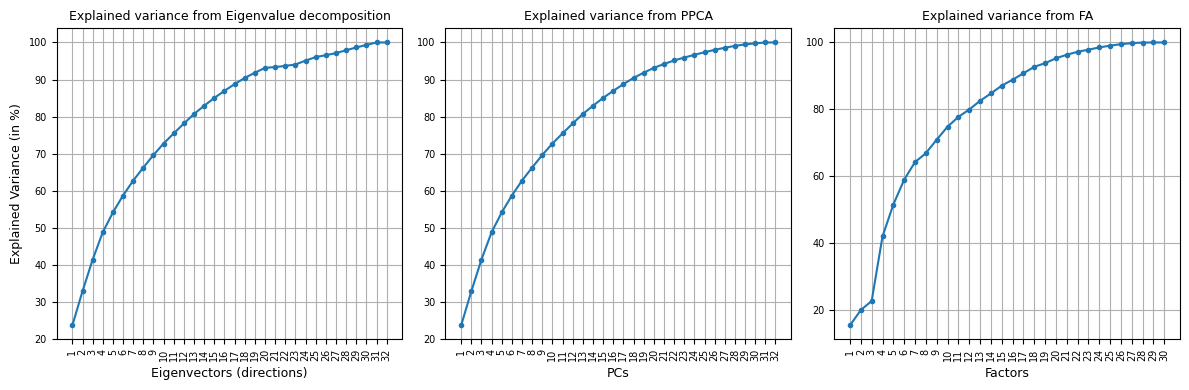

In [13]:
fs=9
f0,(a0, a1,a2)=plt.subplots(1,3,figsize=(12, 4))# Create a scree plot to visualize the explained variance
a0.plot(range(1, len(explained_var) + 1), # x-axis
         explained_var*100, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a0.set_title('Explained variance from Eigenvalue decomposition', fontsize=fs)
a0.set_xlabel('Eigenvectors (directions)', fontsize=fs)
a0.set_ylabel('Explained Variance (in %)', fontsize=fs)
#plt.xtick
# Add label to x-axis
a0.set_xticks(range(1, len(explained_var) + 1))
a0.set_xticklabels(a0.get_xticklabels(), fontsize=fs-2, rotation=90)
a0.set_yticklabels(a0.get_yticklabels(), fontsize=fs-2)
# Add grid in the background
a0.grid(True)
a1.plot(range(1, len(variance_explained) + 1), # x-axis
         variance_explained, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_xticks(range(1, len(variance_explained) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('')
a1.grid()
# Add title and axis label
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a2.plot(range(1, len(var_expl_fa) + 1), np.cumsum(var_expl_fa/sum(var_expl_fa))*100, # convert explained variance in percentage
         marker='o',markersize=3)
a2.set_xticks(range(1, len(var_expl_fa) + 1))
a2.set_xticklabels(a2.get_xticklabels(), fontsize=fs-2, rotation=90)
a2.set_yticklabels(a2.get_yticklabels(), fontsize=fs-2)
a2.set_title('Explained variance from FA', fontsize=fs)
a2.set_xlabel('Factors', fontsize=fs)
a2.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_PPCA_FA_adapted.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_EVD_PPCA_FA_adapted.png'%savetag, bbox_inches='tight', dpi=200)

#### Based on the above findings we will be proceeding with Main, EDtype, Lav, SQ48, MHC_SF, and only one columns of Honos hereon

In [14]:
cols2consider=['age','biosex', 'Education', 'Functioneren']+colsLAV+colsSQ48+colsMHCSF
colNames2=['Main-Age', 'Main-BSex', 'Main-EduLevel','Honos-Functioneren', 'Lav-Neg_Waardering', 'Lav-Gebrek_Vertrouwdheid', 
'Lav-Alg_Ontevredenheid', 'SQ48-Hostility', 'SQ48-Agorafobie', 'SQ48-Angst', 
'SQ48-Depressie', 'SQ48-Cognitieve_Complain', 'SQ48-Somatische_Complain', 
'SQ48-Sociale_Fobie', 'SQ48-Vitaliteit_Optimisme', 'SQ48-Werk_Studie', 
'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB']
colRename_dict=dict(zip(cols2consider, colNames2))
#colRename_dict

In [15]:
df_adapted_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainED_Lav_SQ48_MHCSF_Honos_Visit1.tsv', sep='\t', decimal=',')
df_adapted_combo['bsex'] = df_adapted_combo['bsex'].astype('category')
df_adapted_combo['biosex'] = df_adapted_combo['bsex'].cat.codes
df_adapted_combo['biosex']=df_adapted_combo['biosex'].astype(float)
df_adapted_combo['EDtype'] = df_adapted_combo['EDtype'].astype('category')
df_adapted_combo['ED_Codes'] = df_adapted_combo['EDtype'].cat.codes
df_adapted_combo['Highest_Edu'] = df_adapted_combo['Highest_Edu'].astype('category')
df_adapted_combo['Education'] = df_adapted_combo['Highest_Edu'].cat.codes
df_adapted_combo['Education']=df_adapted_combo['Education'].astype(float)

print(df_adapted_combo.columns)
df_adapted_combo.rename(columns=colRename_dict, inplace=True)

adapted_combo_cols=['Main-Age', 'Main-BSex','Main-EduLevel', 'Honos-Functioneren', 
    'Lav-Alg_Ontevredenheid', 'Lav-Gebrek_Vertrouwdheid','Lav-Neg_Waardering',
    'SQ48-Hostility','SQ48-Agorafobie','SQ48-Angst','SQ48-Depressie','SQ48-Cognitieve_Complain','SQ48-Somatische_Complain', 
    'SQ48-Sociale_Fobie','SQ48-Vitaliteit_Optimisme','SQ48-Werk_Studie', 'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB']
print(df_adapted_combo['pid'].nunique(), df_adapted_combo['intid'].nunique())
print(df_adapted_combo[adapted_combo_cols].columns[df_adapted_combo[adapted_combo_cols].isnull().sum()>0])
df_train_adapted=df_adapted_combo[['intid', 'Split']+adapted_combo_cols].loc[df_adapted_combo['Split']=='Train']
df_test_adapted=df_adapted_combo[['intid', 'Split']+adapted_combo_cols].loc[df_adapted_combo['Split']=='Test']
print(len(adapted_combo_cols))

Index(['Beperkingen', 'Functioneren', 'Gedragsproblemen', 'SocialeProblemen',
       'Somscore', 'Symptomalogie', 'intid', 'p_honos_filled_date',
       'p_honos_filled_date.1', 'p_honos_send_date', 'questionnaire_key',
       'seq_num-honos', 'Algemene_Ontevredenheid', 'Gebrek_Vertrouwdheid',
       'LAV_Score', 'Negatieve_Waardering', 'p_lav_filled_date',
       'p_lav_send_date', 'seq_num-lav', 'pid', 'seq_num-sq48', 'Split',
       'p_sq48_filled_date', 'Vijandigheid', 'Agorafobie', 'Angst',
       'Depressie', 'Cognitieve_Klachten', 'Somatische_Klachten',
       'Sociale_Fobie', 'SQ48score', 'Vitaliteit_Optimisme', 'Werk_Studie',
       'EDEQscore', 'EDtype', 'Highest_Edu', 'age', 'bsex', 'edu_level',
       'p_dischargedate', 'p_startdate', 'seq_num-edeq', 'EmotionWB',
       'PsychWB', 'SocialWB', 'mhcsf_score', 'p_mhcsf_filled_date',
       'seq_num-mhc', 'biosex', 'ED_Codes', 'Education'],
      dtype='object')
165 165
Index([], dtype='object')
19


Shape of eig vec and val (19,) (19, 19)


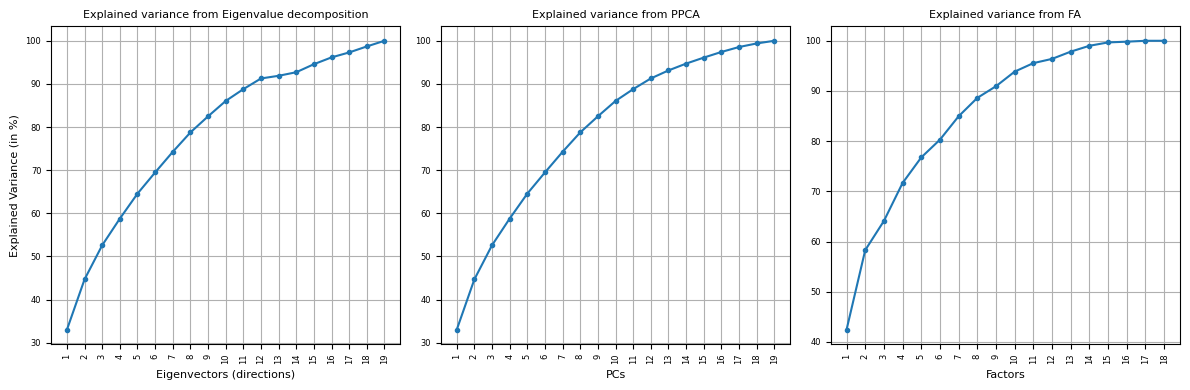

In [17]:
mean_adapted, std_adapted=df_train_adapted[adapted_combo_cols].mean(axis=0), df_train_adapted[adapted_combo_cols].std(axis=0)
z_adapted_train=(df_train_adapted[adapted_combo_cols]-mean_adapted)/std_adapted
z_adapted_test=(df_test_adapted[adapted_combo_cols]-mean_adapted)/std_adapted
eig_val_adapted, eig_vec_adapted=np.linalg.eig(np.dot(z_adapted_train.T, z_adapted_train))
print('Shape of eig vec and val', np.shape(eig_val_adapted), np.shape(eig_vec_adapted))
explained_var_adapted=np.cumsum(eig_val_adapted/np.sum(eig_val_adapted))
sind_eig_val_adapted=np.argsort(-1*(explained_var_adapted))
evd_ndim=15
evd_z_train_adapted=np.dot(z_adapted_train,eig_vec_adapted[sind_eig_val_adapted[:ndim]].T)
pca_adapted = PCA(svd_solver='full').fit(z_adapted_train)
pca_z_train_adapted=pca_adapted.transform(z_adapted_train)
variance_explained_adapt=np.cumsum(pca_adapted.explained_variance_)*100/np.sum(pca_adapted.explained_variance_)
comp_adapt= pca_adapted.components_
fa_adapted = FactorAnalysis(n_components=18, random_state=0)
fa_z_train_adapted = fa_adapted.fit_transform(z_adapted_train)
m, noise = fa_adapted.components_, fa_adapted.noise_variance_
#m1 = 
var_expl_fa, m2 = np.zeros(18,), np.sum(m**2,axis=1)
for idx in range(0,18):
    var_expl_fa[idx]=(100*m2[idx])/(np.sum(m2)+np.sum(noise))

fs=8
fig,(a0, a1,a2)=plt.subplots(1,3,figsize=(12, 4))# Create a scree plot to visualize the explained variance
a0.plot(range(1, len(explained_var_adapted) + 1), explained_var_adapted*100, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a0.set_title('Explained variance from Eigenvalue decomposition', fontsize=fs)
a0.set_xlabel('Eigenvectors (directions)', fontsize=fs)
a0.set_ylabel('Explained Variance (in %)', fontsize=fs)
#plt.xtick
# Add label to x-axis
a0.set_xticks(range(1, len(explained_var_adapted) + 1))
a0.set_xticklabels(a0.get_xticklabels(), fontsize=fs-2, rotation=90)
a0.set_yticklabels(a0.get_yticklabels(), fontsize=fs-2)
# Add grid in the background
a0.grid(True)
a1.plot(range(1, len(variance_explained_adapt) + 1), # x-axis
         variance_explained_adapt, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_xticks(range(1, len(variance_explained_adapt) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('')
a1.grid()
# Add title and axis label
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a2.plot(range(1, len(var_expl_fa) + 1), np.cumsum(var_expl_fa/sum(var_expl_fa))*100,marker='o',markersize=3)
a2.set_xticks(range(1, len(var_expl_fa) + 1))
a2.set_xticklabels(a2.get_xticklabels(), fontsize=fs-2, rotation=90)
a2.set_yticklabels(a2.get_yticklabels(), fontsize=fs-2)
a2.set_title('Explained variance from FA', fontsize=fs)
a2.set_xlabel('Factors', fontsize=fs)
a2.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_PPCA_FA_adapted_reduced.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_EVD_PPCA_FA_adapted_reduced.png'%savetag, bbox_inches='tight', dpi=200)

#### The new cumulative sum of variance suggests that n=10 for all three methods explain more than 80% of the total variance of the dataset

In [18]:
from sklearn.cluster import AffinityPropagation
ndim_opts=np.array([3,4,5,6,10,15,18])
sill_per_dim=[]
for ncomp in ndim_opts:
    fa_gmm_sill=[]
    evd_gmm_sill=[]
    pca_gmm_sill=[]
    for iter in range(0, 10):
        gmm_model_try=GaussianMixture(n_init=20, max_iter=100, n_components=ncomp, covariance_type='spherical', 
                          init_params='k-means++').fit(fa_z_train_adapted)
        fa_gmm_sill.append(metrics.silhouette_score(fa_z_train_adapted, gmm_model_try.predict(fa_z_train_adapted),
                                                    metric="euclidean"))
        gmm_model_try=GaussianMixture(n_init=20, max_iter=100, n_components=ncomp, covariance_type='spherical', 
                          init_params='k-means++').fit(evd_z_train_adapted)
        evd_gmm_sill.append(metrics.silhouette_score(evd_z_train_adapted, gmm_model_try.predict(evd_z_train_adapted),
                                                    metric="cosine"))
        gmm_model_try=GaussianMixture(n_init=20, max_iter=100, n_components=ncomp, covariance_type='spherical', 
                          init_params='k-means++').fit(pca_z_train_adapted)
        pca_gmm_sill.append(metrics.silhouette_score(pca_z_train_adapted, gmm_model_try.predict(pca_z_train_adapted),
                                                    metric="cosine"))
    print('FA, GMM: Avg sill coeff for ndim=%d: %.3f (%.3f)'%(ncomp, np.mean(fa_gmm_sill), np.std(fa_gmm_sill)))   
    print('EVD, GMM: Avg sill coeff for ndim=%d: %.3f (%.3f)'%(ncomp, np.mean(evd_gmm_sill), np.std(evd_gmm_sill)))
    print('PCA, GMM: Avg sill coeff for ndim=%d: %.3f (%.3f)'%(ncomp, np.mean(pca_gmm_sill), np.std(pca_gmm_sill)))

    
sill_per_dim=[]
for fa_ndim in ndim_opts:
    fa_pdist_cos=pairwise_distances(fa_z_train_adapted[:,:fa_ndim], metric='cosine')
    fa_af_sill=[]
    for iter in range(0, 10):
        fa_af = AffinityPropagation(affinity='precomputed',max_iter=50, convergence_iter=5).fit(-1*fa_pdist_cos)
        fa_af_sill.append(metrics.silhouette_score(fa_z_train_adapted[:,:fa_ndim], fa_af.labels_, metric="cosine"))
    print('FA: Avg sill coeff for ndim=%d: %.3f (%.3f)'%(fa_ndim, np.mean(fa_af_sill), np.std(fa_af_sill)))
    sill_per_dim.append(np.mean(fa_af_sill))

fa_adapted = FactorAnalysis(n_components=10, random_state=0)
fa_z_train_adapted = fa_adapted.fit_transform(z_adapted_train)

evd_pdist_cos=pairwise_distances(evd_z_train_adapted[:,:evd_ndim], metric='cosine')
fa_pdist_cos=pairwise_distances(fa_z_train_adapted, metric='cosine')
ndim_opts=np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16, 18])
sill_per_dim=[]
for ppca_ndim in ndim_opts:
    ppca_pdist_cos=pairwise_distances(pca_z_train_adapted[:,:ppca_ndim], metric='cosine')
    ppca_af_sill=[]
    for iter in range(0, 10):
        ppca_af = AffinityPropagation(affinity='precomputed',max_iter=50, convergence_iter=5).fit(-1*ppca_pdist_cos)
        ppca_af_sill.append(metrics.silhouette_score(pca_z_train_adapted[:,:ppca_ndim], ppca_af.labels_, metric="cosine"))
    print('PPCA: Avg sill coeff for ndim=%d: %.3f (%.3f)'%(ppca_ndim, np.mean(ppca_af_sill), np.std(ppca_af_sill)))
    sill_per_dim.append(np.mean(ppca_af_sill))


FA, GMM: Avg sill coeff for ndim=3: 0.009 (0.021)
EVD, GMM: Avg sill coeff for ndim=3: 0.350 (0.092)
PCA, GMM: Avg sill coeff for ndim=3: 0.131 (0.000)
FA, GMM: Avg sill coeff for ndim=4: 0.021 (0.017)
EVD, GMM: Avg sill coeff for ndim=4: 0.163 (0.090)
PCA, GMM: Avg sill coeff for ndim=4: 0.147 (0.001)
FA, GMM: Avg sill coeff for ndim=5: 0.024 (0.026)
EVD, GMM: Avg sill coeff for ndim=5: 0.056 (0.050)
PCA, GMM: Avg sill coeff for ndim=5: 0.154 (0.062)
FA, GMM: Avg sill coeff for ndim=6: 0.032 (0.019)
EVD, GMM: Avg sill coeff for ndim=6: 0.044 (0.096)
PCA, GMM: Avg sill coeff for ndim=6: 0.113 (0.042)
FA, GMM: Avg sill coeff for ndim=10: 0.040 (0.011)
EVD, GMM: Avg sill coeff for ndim=10: -0.027 (0.082)
PCA, GMM: Avg sill coeff for ndim=10: 0.050 (0.038)
FA, GMM: Avg sill coeff for ndim=15: 0.045 (0.011)
EVD, GMM: Avg sill coeff for ndim=15: -0.093 (0.080)
PCA, GMM: Avg sill coeff for ndim=15: 0.027 (0.055)
FA, GMM: Avg sill coeff for ndim=18: 0.054 (0.012)
EVD, GMM: Avg sill coeff for 

In [19]:
#evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:5]].T, mask)
evd_ndim=10
evd_pdist_cos=pairwise_distances(evd_z_train_adapted[:,:evd_ndim], metric='cosine')
evd_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=5,
                        ).fit(-1*evd_pdist_cos)
evd_cluster_centers_indices, evd_labels = evd_af.cluster_centers_indices_, evd_af.labels_
np.fill_diagonal(evd_pdist_cos, 0)
labels_true=df_adapted_combo['ED_Codes'].loc[df_adapted_combo['Split']=='Train']
evd_n_clusters_ = len(evd_cluster_centers_indices)
print("Estimated number of clusters: %d" % evd_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, evd_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, evd_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, evd_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, evd_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, evd_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(evd_pdist_cos, evd_labels, metric="precomputed"))
z_df_train_explore=pd.DataFrame(z_train_explore, columns=cols2train)

Estimated number of clusters: 11
Homogeneity: 0.164
Completeness: 0.109
V-measure: 0.131
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.032
Silhouette Coefficient: 0.474


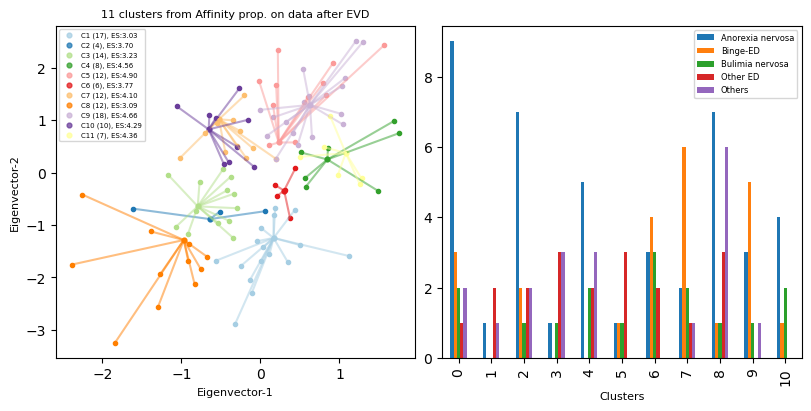

In [20]:
#savetag='combinedDatasets2'
cluster_model={'model': evd_af, 'name': 'Affinity', 'pred_labels': evd_labels,
               'cluster_center_indices':evd_cluster_centers_indices}
df_train_=df_adapted_combo[adapted_combo_cols+['EDtype', 'EDEQscore']].loc[df_adapted_combo['Split']=='Train']
z_adapted_train['EDtype']=df_train_['EDtype']
z_adapted_train['EDEQscore']=df_train_['EDEQscore']
#evd_z_train_adapted['EDtype']=df_train_['EDtype']
data_tabs={'data_to_cluster': evd_pdist_cos, 'data_to_plot': evd_z_train_adapted,
    'df': df_train_,'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['EVD_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper left', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_ed_cluster_df, ed_evd_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

(11, 11)


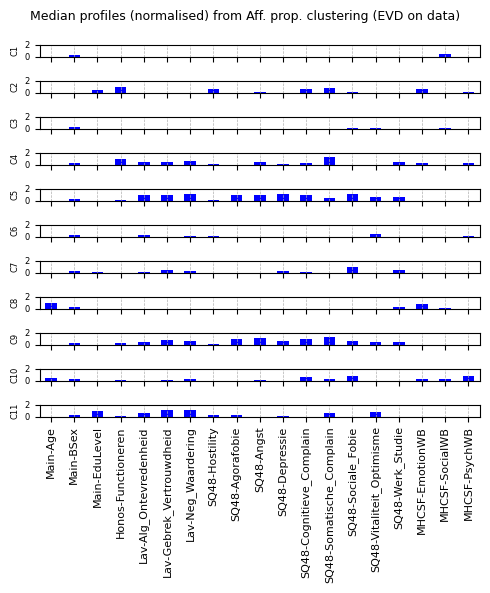

<Figure size 400x300 with 0 Axes>

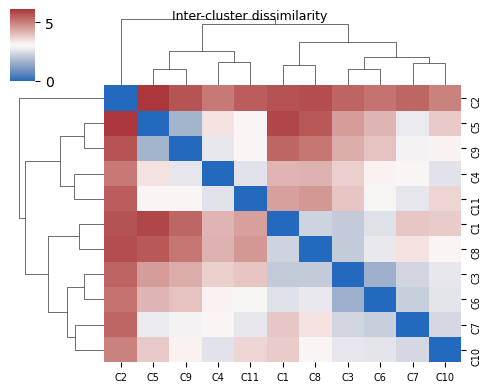

In [21]:
fig31, ax31 = plt.subplots(nrows=evd_n_clusters_, ncols=1, figsize=(5,6), constrained_layout=True)
#colnames=np.setdiff1d(af_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
#zs_evd_ed_cluster_df.rename(columns=dict(zip(cols2train, colNames2)), inplace=True)
prof_colnames=zs_evd_ed_cluster_df.columns
for nrow in range(0,evd_n_clusters_):
    df_temp=zs_evd_ed_cluster_df.iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax31[nrow])
    ax31[nrow].set_ylim(0, 2)
    ax31[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax31[nrow].set_yticklabels(ax31[nrow].get_yticklabels(), fontsize=6)
    if nrow<evd_n_clusters_-1:        
        ax31[nrow].set_xticklabels('')
    else:
        ax31[nrow].set_xticklabels(prof_colnames, fontsize=8)    
    ax31[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig31.suptitle('Median profiles (normalised) from Aff. prop. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_AP_Profiles.pdf'%savetag,bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_EVD_AP_Profiles.png'%savetag,bbox_inches='tight', dpi=200)

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
fig32= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_evd_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig32=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig32.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig32.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig32.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig32.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
#fig32.tight_layout()
fig32.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_AP_EVD.pdf'%savetag, bbox_inches='tight', dpi=200)
fig32.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_AP_EVD.png'%savetag, bbox_inches='tight', dpi=200)

#### Trying Affinity Propagation without any dimensionality reduction (i.e., without EVD or PPCA)

In [22]:
#pdist_cos = np.zeros((np.shape(z_train_explore)[0],np.shape(z_adatrain_explore)[0]))
pdist_cos=pairwise_distances(z_adapted_train[adapted_combo_cols], metric='cosine')
af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=500, convergence_iter=20).fit(-1*pdist_cos)
t_cluster_centers_indices, t_labels, t_n_clusters_ = af.cluster_centers_indices_, af.labels_, len(af.cluster_centers_indices_)
print("Estimated number of clusters: %d" % t_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, t_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, t_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, t_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, t_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, t_labels))
np.fill_diagonal(pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pdist_cos, t_labels, metric="precomputed"))

Estimated number of clusters: 16
Homogeneity: 0.331
Completeness: 0.190
V-measure: 0.242
Adjusted Rand Index: 0.048
Adjusted Mutual Information: 0.116
Silhouette Coefficient: 0.163


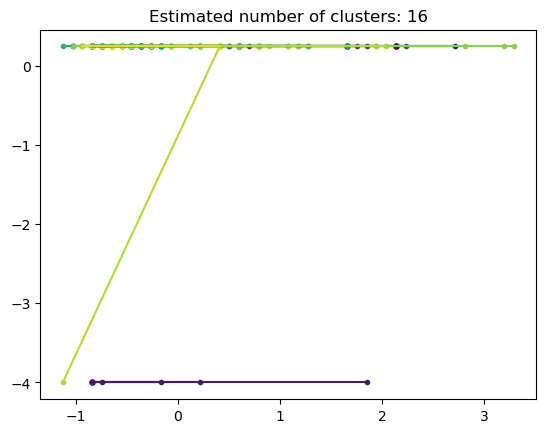

In [23]:
plt.figure(0)
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, t_n_clusters_+1)))
for k, col in zip(range(t_n_clusters_), colors):
    class_members = t_labels == k
    cluster_center = z_adapted_train.to_numpy()[t_cluster_centers_indices[k]]
    #cluster_center=cluster_center[cluster_centers_indices[k]]
    plt.scatter(z_adapted_train.to_numpy()[class_members, 0], z_adapted_train.to_numpy()[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in z_adapted_train.to_numpy()[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])
plt.title("Estimated number of clusters: %d" % t_n_clusters_)
plt.show()

#### Clustering with Gaussian Mixture models

In [24]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [22]:
param_grid = {"n_components": range(3, 15),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
ndim=10
grid_search = GridSearchCV(GaussianMixture(n_init=20, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(evd_z_train_adapted)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
72,3,spherical,kmeans,238.546987
96,3,spherical,random_from_data,238.737081
84,3,spherical,k-means++,238.956559
73,4,spherical,kmeans,252.930591
85,4,spherical,k-means++,253.199664


In [25]:
ndim=10
iters, n_components, data_to_cluster=5, 4, evd_z_train_adapted#[:,:ndim]
sill=np.zeros(iters,)
for iter in range(0,iters):
    gmm_model_try=GaussianMixture(n_init=20, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, gmm_model_try.predict(data_to_cluster), metric="cosine")
    
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
evd_gmm_model=GaussianMixture(n_init=20, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans', random_state=101).fit(data_to_cluster)
evd_gmm_labels=evd_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"%(metrics.silhouette_score(data_to_cluster, evd_gmm_labels, metric="cosine")) )
evd_gmm_ED_cluster=df_adapted_combo[['EDtype', 'EDEQscore']].loc[df_adapted_combo['Split']=='Train']
evd_gmm_ED_cluster['GMMcluster']=evd_gmm_labels

Average silhouette Coefficient: 0.251 (0.014)
Silhouette Coefficient: 0.249


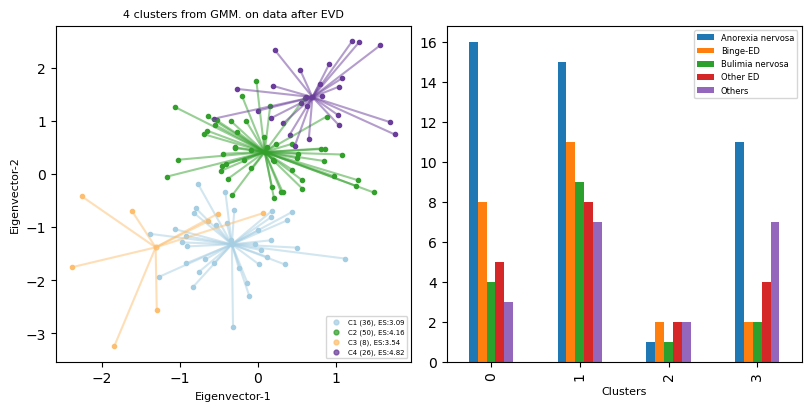

In [26]:
cluster_model={'model': evd_gmm_model, 'name': 'GMM', 'pred_labels': evd_gmm_labels}
data_tabs={'data_to_cluster':evd_z_train_explore, 'data_to_plot': evd_z_train_adapted,'df': df_train_,
          'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['EVD_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower right', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_gmm_ed_cluster_df, ed_evd_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

#### Representative profiles of each cluster

(4, 4)


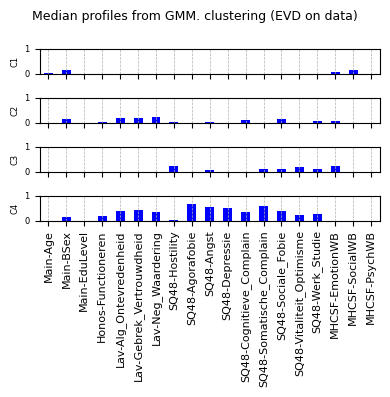

<Figure size 400x300 with 0 Axes>

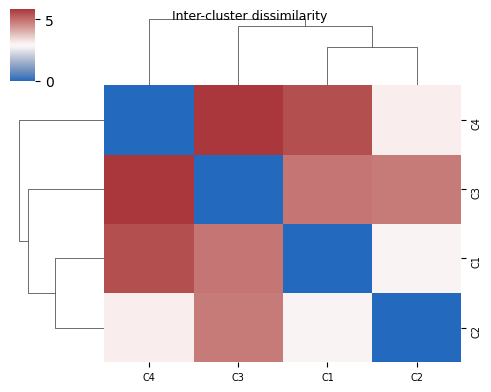

In [27]:
fig51, ax51 = plt.subplots(nrows=n_components, ncols=1, figsize=(4,4), constrained_layout=True)
colnames=zs_evd_gmm_ed_cluster_df.columns#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,n_components):
    df_temp=zs_evd_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax51[nrow])
    ax51[nrow].set_ylim(0, 2)
    ax51[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax51[nrow].set_yticklabels(ax51[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax51[nrow].set_xticklabels('')
    else:
        ax51[nrow].set_xticklabels(colnames, fontsize=8)    
    ax51[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig51.suptitle('Median profiles from GMM. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_GMM_Profiles.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_EVD_GMM_Profiles.png'%savetag, bbox_inches='tight', dpi=200)

fig52= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_evd_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig52=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')
fig52.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig52.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig52.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig52.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
fig52.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_GMM_EVD.pdf'%savetag,bbox_inches='tight', dpi=200)
fig52.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_GMM_EVD.png'%savetag, bbox_inches='tight', dpi=200)

In [28]:
param_grid2 = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
ndim=3
grid_search2 = GridSearchCV(GaussianMixture(n_init=5, max_iter=300), param_grid=param_grid2, scoring=gmm_bic_score)
grid_search2.fit(comp_adapt)
df2 = pd.DataFrame(grid_search2.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df2["mean_test_score"] = -df2["mean_test_score"]
df2 = df2.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df2.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
63,3,spherical,k-means++,82.094532
72,3,spherical,random_from_data,82.094532
54,3,spherical,kmeans,82.190508
55,4,spherical,kmeans,111.021924
73,4,spherical,random_from_data,112.724433


In [30]:
ndim=10
n_components, data_to_cluster=7, pca_z_train_adapted[:,:ndim]
sill=np.zeros(iters,)
for iter in range(0,iters):
    ppca_gmm_model_try=GaussianMixture(n_init=3, max_iter=200, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, ppca_gmm_model_try.predict(data_to_cluster), metric="cosine")
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
ppca_gmm_model=GaussianMixture(n_init=3, max_iter=200, n_components=n_components, 
        covariance_type='spherical', init_params='kmeans', random_state=101).fit(data_to_cluster)
ppca_gmm_labels=ppca_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, ppca_gmm_labels, metric="cosine"))
ppca_gmm_ED_cluster=df_train_.copy()#explore[['EDtype', 'EDEQscore']].copy()
ppca_gmm_ED_cluster['GMMcluster']=ppca_gmm_labels

Average silhouette Coefficient: 0.122 (0.035)
Silhouette Coefficient: 0.177


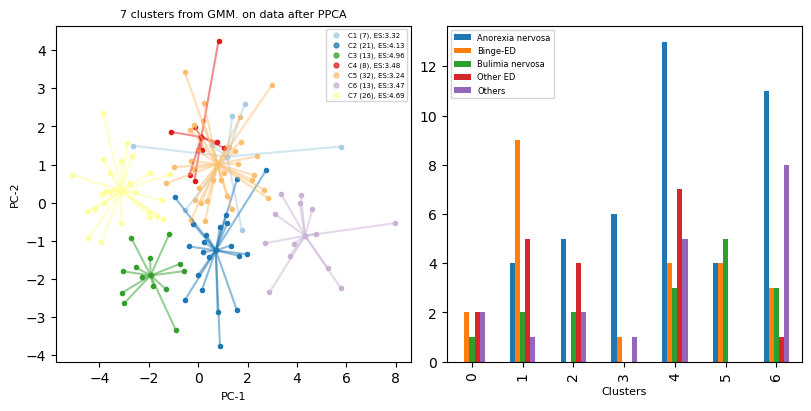

In [31]:
cluster_model={'model': ppca_gmm_model, 'name': 'GMM', 'pred_labels': ppca_gmm_labels}
data_tabs={'data_to_cluster':pca_z_train_adapted[:,:ndim], 'data_to_plot': pca_z_train_adapted[:,:ndim],'df': df_train_,
          'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['PPCA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after PPCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_gmm_ed_cluster_df, ed_ppca_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

(7, 7)


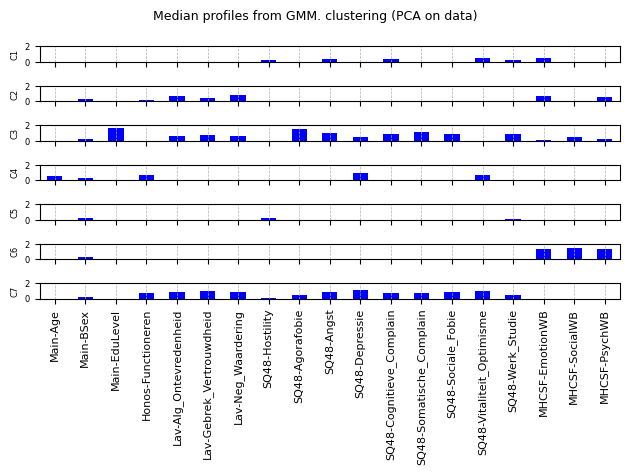

<Figure size 400x300 with 0 Axes>

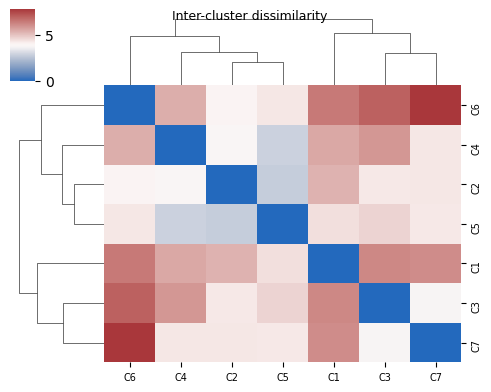

In [32]:
fig71, ax71 = plt.subplots(nrows=n_components, ncols=1)
colnames=adapted_combo_cols#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,n_components):
    df_temp=zs_ppca_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax71[nrow])
    ax71[nrow].set_ylim(0, 2)
    ax71[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax71[nrow].set_yticklabels(ax71[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax71[nrow].set_xticklabels('')
    else:
        ax71[nrow].set_xticklabels(colnames, fontsize=8)    
    ax71[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig71.suptitle('Median profiles from GMM. clustering (PCA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_GMM_Profiles.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_EVD_GMM_Profiles.png'%savetag, bbox_inches='tight', dpi=200)

fig72= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_ppca_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig72=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig72.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig72.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig72.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig72.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
fig72.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_GMM_PCA.pdf'%savetag, bbox_inches='tight', dpi=200)
fig72.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_GMM_PCA.png'%savetag, bbox_inches='tight', dpi=200)

Average silhouette Coefficient: 0.058 (0.032)
Silhouette Coefficient: 0.085


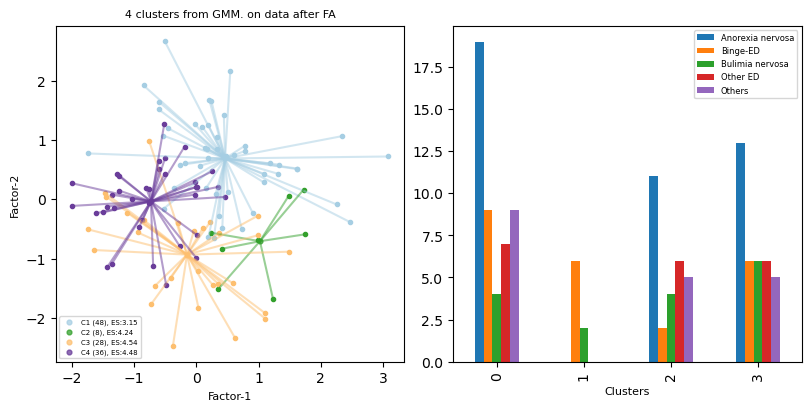

In [33]:
ndim=10
n_components, data_to_cluster=4, fa_z_train_adapted[:,:ndim]
sill=np.zeros(iters,)
for iter in range(0,iters):
    fa_gmm_model_try=GaussianMixture(n_init=3, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, fa_gmm_model_try.predict(data_to_cluster), metric="cosine")
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
fa_gmm_model=GaussianMixture(n_init=3, max_iter=100, n_components=n_components, 
        covariance_type='spherical', init_params='kmeans', random_state=100).fit(data_to_cluster)
fa_gmm_labels=fa_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, fa_gmm_labels, metric="cosine"))
fa_gmm_ED_cluster=df_train_.copy()#df_train_explore[['EDtype', 'EDEQscore']].copy()
fa_gmm_ED_cluster['GMMcluster']=fa_gmm_labels

cluster_model={'model': fa_gmm_model, 'name': 'GMM', 'pred_labels': fa_gmm_labels}
data_tabs={'data_to_cluster':fa_z_train_adapted, 'data_to_plot': data_to_cluster,'df': df_train_,
          'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['FA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after FA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}
zs_fa_gmm_ed_cluster_df, ed_fa_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

(4, 4)


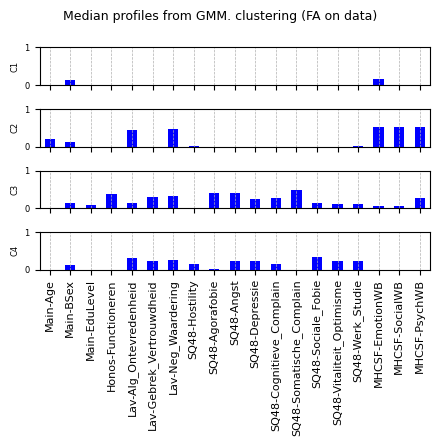

<Figure size 400x300 with 0 Axes>

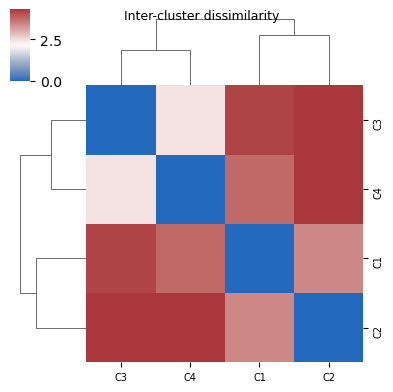

In [34]:
fig81, ax81 = plt.subplots(nrows=n_components, ncols=1, figsize=(4.5,4.5))
colnames=adapted_combo_cols
for nrow in range(0,n_components):
    df_temp=zs_fa_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax81[nrow])
    ax81[nrow].set_ylim(0, 2)
    ax81[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax81[nrow].set_yticklabels(ax81[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax81[nrow].set_xticklabels('')
    else:
        ax81[nrow].set_xticklabels(colnames, fontsize=8)    
    ax81[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig81.suptitle('Median profiles from GMM. clustering (FA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_FA_GMM_Profiles.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_FA_GMM_Profiles.png'%savetag, bbox_inches='tight', dpi=200)

fig82= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_fa_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig82=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(4,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig82.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig82.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig82.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig82.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
fig82.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_GMM_FA.pdf'%savetag, bbox_inches='tight', dpi=200)
fig82.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_GMM_FA.png'%savetag, bbox_inches='tight', dpi=200)

#### Agglomerative clustering